<a href="https://colab.research.google.com/github/gregorio-saporito/hate-speech-detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mining and Sentiment Analysis: Hate Speech Detection
Gregorio Luigi Saporito - DSE (2020-2021)

### Libraries

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt

### Upload the data to session storage
Upload here below the __labeled_data.csv__ file. The labels correspond to
- 0: hate speech
- 1: offensive language
- 2: neither

In [2]:
# upload here the data
uploaded = files.upload()

Saving labeled_data.csv to labeled_data.csv


In [3]:
# read the csv file and rename the columns
fields = ['Unnamed: 0', 'class', 'tweet']
raw = pd.read_csv('labeled_data.csv', usecols=fields)\
  .rename(columns={"Unnamed: 0": "id", "class": "label"})

### Inspect the data

In [4]:
# snapshot of the first rows
raw.head()

,id,label,tweet
0,0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
# size of the dataset
raw.shape

(24783, 3)

In [24]:
# inspect the presence of missing values
print(
    'Check for null values\n' +
    str(raw.isnull().sum()) + '\n'
    'Check for na values\n' +
    str(raw.isna().sum())
)

Check for null values
id       0
label    0
tweet    0
dtype: int64
Check for na values
id       0
label    0
tweet    0
dtype: int64


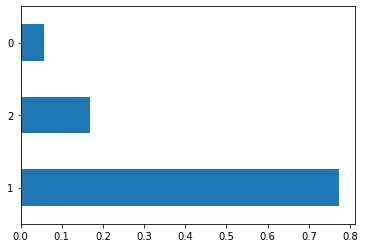

In [27]:
# check the frequency of classes
raw.label.value_counts(normalize=True).plot.barh()
plt.show()